In [31]:
import pandas as pd
data = pd.read_csv("/Users/ethanschultz/Documents/GSB 544/Week-7/Hitters.csv")
data_clean = data.dropna()

In [63]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np


In [33]:
X = data_clean.drop("Salary", axis = 1)
y = data_clean["Salary"]



X_train, X_test, y_train, y_test = train_test_split(X, y)

In [34]:

numeric_features = ["AtBat", "Hits", "HmRun", "Runs", "RBI", "Walks", "Years", 
                    "CAtBat", "CHits", "CHmRun", "CRuns", "CRBI", "CWalks", 
                    "PutOuts", "Assists", "Errors"]
categorical_features = ["League", "Division", "NewLeague"]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ],
    remainder='passthrough'
)

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('linear regression', LinearRegression())
])

pipeline.fit(X_train, y_train)

print("Intercept:", pipeline.named_steps['linear regression'].intercept_)

feature_names = preprocessor.get_feature_names_out()

coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': pipeline.named_steps['linear regression'].coef_
})
print(coefficients_df)

mse_scores = cross_val_score(pipeline, X, y, scoring='neg_mean_squared_error', cv=5)
mean_mse = -np.mean(mse_scores)
print("Estimated MSE:", mean_mse)

Intercept: 539.7531851626582
             Feature  Coefficient
0         num__AtBat  -210.509817
1          num__Hits   273.797801
2         num__HmRun    49.697168
3          num__Runs   -25.583174
4           num__RBI   -44.081370
5         num__Walks    87.599460
6         num__Years   -15.634255
7        num__CAtBat  -488.845998
8         num__CHits   442.788940
9        num__CHmRun    80.629906
10        num__CRuns   213.850600
11         num__CRBI   153.471454
12       num__CWalks  -164.983500
13      num__PutOuts    85.375610
14      num__Assists    46.134408
15       num__Errors   -25.680269
16     cat__League_A   -18.609576
17     cat__League_N    18.609576
18   cat__Division_E    68.623642
19   cat__Division_W   -68.623642
20  cat__NewLeague_A    -3.013978
21  cat__NewLeague_N     3.013978
Estimated MSE: 121136.31031816886
Intercept: 539.7531851626582
             Feature  Coefficient
0         num__AtBat  -210.509817
1          num__Hits   273.797801
2         num__HmRun    

The MSE for this model is 1211136. Some coefficient interpretations are for every additional run in a players career their salary increases by $213,850 holding all else constant. For every additional walk in a players career their salary is predicted to decrease by $164,983 holding all else constant. For every additional hit that player had in 1986 their salary is predicted to increase by $273,797 holding all else constant.

In [35]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('ridge', Ridge())
])

param_grid = {'ridge__alpha': [0.1, 1.0, 10, 100, 1000]}

ridge_cv = GridSearchCV(ridge_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_cv.fit(X, y)

ridge_best_model = ridge_cv.best_estimator_
ridge_mse = -ridge_cv.best_score_
print("Best alpha for Ridge:", ridge_cv.best_params_)
print("Estimated MSE for Ridge:", ridge_mse)

feature_names = ridge_best_model.named_steps['preprocessor'].get_feature_names_out()

coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': ridge_best_model.named_steps['ridge'].coef_
})
coefficients_df

Best alpha for Ridge: {'ridge__alpha': 1.0}
Estimated MSE for Ridge: 119144.43267691608
Best alpha for Ridge: {'ridge__alpha': 1.0}
Estimated MSE for Ridge: 119144.43267691608


,Feature,Coefficient
0,num__AtBat,-270.686441
1,num__Hits,296.645050
2,num__HmRun,18.100592
3,num__Runs,-29.339406
4,num__RBI,-9.113295
5,num__Walks,124.407173
6,num__Years,-38.667748
7,num__CAtBat,-225.406548
8,num__CHits,126.659607
9,num__CHmRun,39.070924


The MSE for this model is 119144. Some coefficiant interpretations are for every additional RBI in a players career he will make an additional $160,386. If the player ended the season in the American league he will on average earn $30,438 less than if he was in the National league. For every additional asist a player has in their career thier salary is predicted to increase by $47,462.

In [36]:
from sklearn.linear_model import Lasso

lasso_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('lasso', Lasso(max_iter=10000))
])

param_grid = {'lasso__alpha': [0.001, 0.01, 0.1, 1.0, 10]}

lasso_cv = GridSearchCV(lasso_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
lasso_cv.fit(X, y)

lasso_best_model = lasso_cv.best_estimator_
lasso_mse = -lasso_cv.best_score_
print("Best alpha for Lasso:", lasso_cv.best_params_)
print("Estimated MSE for Lasso:", lasso_mse)

feature_names = lasso_best_model.named_steps['preprocessor'].get_feature_names_out()

coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': lasso_best_model.named_steps['lasso'].coef_
})
print(coefficients_df)

Best alpha for Lasso: {'lasso__alpha': 1.0}
Estimated MSE for Lasso: 119758.22781528854
             Feature   Coefficient
0         num__AtBat -2.823696e+02
1          num__Hits  3.043583e+02
2         num__HmRun  1.112715e+01
3          num__Runs -2.496605e+01
4           num__RBI -0.000000e+00
5         num__Walks  1.206948e+02
6         num__Years -3.494751e+01
7        num__CAtBat -1.626441e+02
8         num__CHits  0.000000e+00
9        num__CHmRun  1.422286e+01
10        num__CRuns  3.755650e+02
11         num__CRBI  1.926164e+02
12       num__CWalks -1.896431e+02
13      num__PutOuts  7.876026e+01
14      num__Assists  4.199666e+01
15       num__Errors -1.847942e+01
16     cat__League_A -3.582608e+01
17     cat__League_N  8.673601e-15
18   cat__Division_E  1.144130e+02
19   cat__Division_W -2.055233e-11
20  cat__NewLeague_A  0.000000e+00
21  cat__NewLeague_N -0.000000e+00
Best alpha for Lasso: {'lasso__alpha': 1.0}
Estimated MSE for Lasso: 119758.22781528854
             Featur

The MSE for this model is 119758. For every additional error a player has throughout their career their salary is predicted to decrease by $18,479. For every additional walk a plyers has throughout their career their salary is predicted to decrease $189,643. For every additiohnal run a player has throught their career their predicted salary will increase by $375,565.

In [37]:
from sklearn.linear_model import ElasticNet

elastic_net_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('elasticnet', ElasticNet(max_iter=10000))
])

param_grid = {
    'elasticnet__alpha': [0.001, 0.01, 0.1, 1.0, 10],
    'elasticnet__l1_ratio': [0.2, 0.5, 0.8]
}

elastic_net_cv = GridSearchCV(elastic_net_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
elastic_net_cv.fit(X, y)

elastic_net_best_model = elastic_net_cv.best_estimator_
elastic_net_mse = -elastic_net_cv.best_score_
print("Best alpha and l1_ratio for Elastic Net:", elastic_net_cv.best_params_)
print("Estimated MSE for Elastic Net:", elastic_net_mse)

feature_names = elastic_net_best_model.named_steps['preprocessor'].get_feature_names_out()

coefficients_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': elastic_net_best_model.named_steps['elasticnet'].coef_
})

coefficients_df


Best alpha and l1_ratio for Elastic Net: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8}
Estimated MSE for Elastic Net: 118994.44721070088
Best alpha and l1_ratio for Elastic Net: {'elasticnet__alpha': 0.1, 'elasticnet__l1_ratio': 0.8}
Estimated MSE for Elastic Net: 118994.44721070088


,Feature,Coefficient
0,num__AtBat,-184.994814
1,num__Hits,200.550645
2,num__HmRun,-3.276012
3,num__Runs,9.357995
4,num__RBI,9.378484
5,num__Walks,97.555040
6,num__Years,-52.179396
7,num__CAtBat,-56.856299
8,num__CHits,110.750979
9,num__CHmRun,59.255198


The MSE for this model is 118994. For every additional RBI in a players career their are predicted to make $104,774 more holding all else constant. For every additonal walk in a players career their salary decreases by $125,752, holding all else constant. For every additional run in a players career their predicted salary will increase by $163,219.

Part 2

The single numeric variable that is most important: Hits
5 most important numeric: num__AtBat,num__Hits,num__CHmRun,num__CRuns,num__CWalks
Most important categorical: cat__Division_W

In [72]:

def single_variable(X, y, modeltype):
    pipeline = Pipeline([
        ("scaler", StandardScaler())
    ])
    
    if modeltype == "OLS":
        model = LinearRegression()
        pipeline.steps.append(("model", model))
        scores = cross_val_score(pipeline, X, y, cv=5, scoring="neg_mean_squared_error")
        mean_mse = -scores.mean()
        best_params = {}
    
    elif modeltype == "Ridge":
        model = Ridge()
        param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10]}
        pipeline.steps.append(("model", model))
        grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_squared_error", cv=5)
        grid_search.fit(X, y)
        mean_mse = -grid_search.best_score_
        best_params = grid_search.best_params_
    
    elif modeltype == "Lasso":
        model = Lasso()
        param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10]}
        pipeline.steps.append(("model", model))
        grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_squared_error", cv=5)
        grid_search.fit(X, y)
        mean_mse = -grid_search.best_score_
        best_params = grid_search.best_params_
    
    elif modeltype == "ElasticNet":
        model = ElasticNet()
        param_grid = {
            'model__alpha': [0.001, 0.01, 0.1, 1, 10],
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
        pipeline.steps.append(("model", model))
        grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_squared_error", cv=5)
        grid_search.fit(X, y)
        mean_mse = -grid_search.best_score_
        best_params = grid_search.best_params_

    results = {
        "Model": modeltype,
        "Best MSE": mean_mse,
        "Best Params": best_params
    }

    return results

X = data_clean[["Hits"]]
y = data_clean["Salary"]

results_ols = single_variable(X, y, modeltype="OLS")
results_ridge = single_variable(X, y, modeltype="Ridge")
results_lasso = single_variable(X, y, modeltype="Lasso")
results_elasticnet = single_variable(X, y, modeltype="ElasticNet")

results_df = pd.DataFrame([results_ols, results_ridge, results_lasso, results_elasticnet])
print("Model Evaluation Using the 'Hits' Variable with Hyperparameter Tuning:")
print(results_df)


Model Evaluation Using the 'Hits' Variable with Hyperparameter Tuning:
        Model       Best MSE                                    Best Params
0         OLS  173088.972864                                             {}
1       Ridge  172755.975523                           {'model__alpha': 10}
2       Lasso  173061.634500                           {'model__alpha': 10}
3  ElasticNet  172603.554302  {'model__alpha': 0.1, 'model__l1_ratio': 0.1}
Model Evaluation Using the 'Hits' Variable with Hyperparameter Tuning:
        Model       Best MSE                                    Best Params
0         OLS  173088.972864                                             {}
1       Ridge  172755.975523                           {'model__alpha': 10}
2       Lasso  173061.634500                           {'model__alpha': 10}
3  ElasticNet  172603.554302  {'model__alpha': 0.1, 'model__l1_ratio': 0.1}


The elastic net model produced the smallest MSE as it did prior aswell.

In [73]:

X = data_clean[["Hits","AtBat","CHmRun","CWalks","CRuns"]]  
y = data_clean["Salary"]

results_ols = single_variable(X, y, modeltype="OLS")
results_ridge = single_variable(X, y, modeltype="Ridge")
results_lasso = single_variable(X, y, modeltype="Lasso")
results_elasticnet = single_variable(X, y, modeltype="ElasticNet")

results_df = pd.DataFrame([results_ols, results_ridge, results_lasso, results_elasticnet])
print("Model Evaluation Using Only the 'Hits' Variable:")
print(results_df)


Model Evaluation Using Only the 'Hits' Variable:
        Model       Best MSE                                     Best Params
0         OLS  125814.127913                                              {}
1       Ridge  125555.931278                             {'model__alpha': 1}
2       Lasso  125682.929425                             {'model__alpha': 1}
3  ElasticNet  125499.742138  {'model__alpha': 0.01, 'model__l1_ratio': 0.1}
Model Evaluation Using Only the 'Hits' Variable:
        Model       Best MSE                                     Best Params
0         OLS  125814.127913                                              {}
1       Ridge  125555.931278                             {'model__alpha': 1}
2       Lasso  125682.929425                             {'model__alpha': 1}
3  ElasticNet  125499.742138  {'model__alpha': 0.01, 'model__l1_ratio': 0.1}


Again with all five most important numeric varibles the elastic net model is the best

In [74]:

def five_variable_with_interactions(X, y, modeltype):
    numeric_features = ["Hits", "AtBat", "CHmRun", "CWalks", "CRuns"]
    categorical_features = ["Division"]

    ct = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(), categorical_features)
        ],
        remainder="passthrough"
    )
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    
    if modeltype == "OLS":
        model = LinearRegression()
        pipeline = Pipeline([
            ("preprocessing", ct),
            ("interaction", poly),
            ("model", model)
        ])
        scores = cross_val_score(pipeline, X, y, cv=5, scoring="neg_mean_squared_error")
        mean_mse = -scores.mean()
        best_params = {}
    
    elif modeltype == "Ridge":
        model = Ridge()
        param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10]}
        pipeline = Pipeline([
            ("preprocessing", ct),
            ("interaction", poly),
            ("model", model)
        ])
        grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_squared_error", cv=5)
        grid_search.fit(X, y)
        mean_mse = -grid_search.best_score_
        best_params = grid_search.best_params_
    
    elif modeltype == "Lasso":
        model = Lasso()
        param_grid = {'model__alpha': [0.001, 0.01, 0.1, 1, 10]}
        pipeline = Pipeline([
            ("preprocessing", ct),
            ("interaction", poly),
            ("model", model)
        ])
        grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_squared_error", cv=5)
        grid_search.fit(X, y)
        mean_mse = -grid_search.best_score_
        best_params = grid_search.best_params_
    
    elif modeltype == "ElasticNet":
        model = ElasticNet()
        param_grid = {
            'model__alpha': [0.001, 0.01, 0.1, 1, 10],
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
        pipeline = Pipeline([
            ("preprocessing", ct),
            ("interaction", poly),
            ("model", model)
        ])
        grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_squared_error", cv=5)
        grid_search.fit(X, y)
        mean_mse = -grid_search.best_score_
        best_params = grid_search.best_params_

    results = {
        "Model": modeltype,
        "Best MSE": mean_mse,
        "Best Params": best_params
    }

    return results

X = data_clean[["Hits", "AtBat", "CHmRun", "CWalks", "CRuns", "Division"]]
y = data_clean["Salary"]

results_ols = five_variable_with_interactions(X, y, modeltype="OLS")
results_ridge = five_variable_with_interactions(X, y, modeltype="Ridge")
results_lasso = five_variable_with_interactions(X, y, modeltype="Lasso")
results_elasticnet = five_variable_with_interactions(X, y, modeltype="ElasticNet")

results_df = pd.DataFrame([results_ols, results_ridge, results_lasso, results_elasticnet])

print("Model Evaluation Using Five Numeric Variables and Interactions with 'Division':")
print(results_df)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.271e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.725e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.086e+06, toler

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.535e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.037e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.309e+06, toler

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.520e+06, tolerance: 4.708e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.033e+06, tolerance: 3.606e+03
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.510e+06, toler

Model Evaluation Using Five Numeric Variables and Interactions with 'Division':
        Model       Best MSE                                  Best Params
0         OLS  175355.605061                                           {}
1       Ridge  135373.557586                         {'model__alpha': 10}
2       Lasso  133799.828030                         {'model__alpha': 10}
3  ElasticNet  102418.361650  {'model__alpha': 1, 'model__l1_ratio': 0.3}
Model Evaluation Using Five Numeric Variables and Interactions with 'Division':
        Model       Best MSE                                  Best Params
0         OLS  175355.605061                                           {}
1       Ridge  135373.557586                         {'model__alpha': 10}
2       Lasso  133799.828030                         {'model__alpha': 10}
3  ElasticNet  102418.361650  {'model__alpha': 1, 'model__l1_ratio': 0.3}


Again the elastic net model worked best and this is the best model of them all with the lowest MSE.

Part 3

A.
My coefficients in the ridge models were generally smaller than those of the regression model. This makes sense because ridge penalizes the coefficients which has this shrinking effetc that we saw throught the different models when comapring the two. Regression does not penalize like this thus thelarger coefficients

B.
The lasso models in part 1 and the lasso models in part 2 had some similar but also some different alpha results. This makes sense becasue all these different models contained different combinations of variables which chhnages how the model preforms and therefore alpha levels can be different it just so happned that some were the same. This thinking also applies the why we got different MSE's and as we put in more terms the MSE's got smaller

C.
The elastic model always had the best MSE which makes sense becasue it is a combination of the features that Lasso and Ridge utalize so you get the best of both worlds and a the smallest MSE.

Part 4

In [93]:
def five_variable_with_interactions(X, y, modeltype):
    numeric_features = ["Hits", "AtBat", "CHmRun", "CWalks", "CRuns","HmRun","Runs","RBI","Walks","Years","CAtBat","CHits","PutOuts","Assists","Errors"]
    categorical_features = ["Division", "League", "NewLeague"]

    ct = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), numeric_features),
            ("cat", OneHotEncoder(), categorical_features)
        ],
        remainder="passthrough"
    )
    
    poly = PolynomialFeatures(interaction_only=True, include_bias=False)
    
    if modeltype == "ElasticNet":
        model = ElasticNet()
        param_grid = {
            'model__alpha': [0.001, 0.01, 0.1, 1, 10],
            'model__l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
        }
        pipeline = Pipeline([
            ("preprocessing", ct),
            ("interaction", poly),
            ("model", model)
        ])
        grid_search = GridSearchCV(pipeline, param_grid, scoring="neg_mean_squared_error", cv=5)
        grid_search.fit(X, y)
        mean_mse = -grid_search.best_score_
        best_params = grid_search.best_params_
    
    return grid_search

X = data_clean.drop("Salary", axis=1)
y = data_clean["Salary"]

grid_search = five_variable_with_interactions(X, y, modeltype="ElasticNet")

best_pipeline = grid_search.best_estimator_

predictions = best_pipeline.predict(X)

prediction_df = pd.DataFrame({
    'True Values': y,
    'Predicted Values': predictions
})



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.590e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.405e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.563e+06, tolerance: 4.137e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.681e+05, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.526e+06, tolerance: 4.708e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.354e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.505e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.367e+05, tolerance: 4.281e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.393e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.449e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.295e+06, tolerance: 3.606e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.434e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.000e+05, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.316e+06, tolerance: 4.558e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.351e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.224e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.342e+06, tolerance: 4.137e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.554e+05, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.221e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.210e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.207e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.962e+05, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.089e+06, tolerance: 4.558e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.406e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.323e+06, tolerance: 4.137e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.340e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.366e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.300e+06, tolerance: 4.708e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.225e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.276e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.167e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.933e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.101e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.099e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.985e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.755e+06, tolerance: 3.606e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.930e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.083e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.890e+06, tolerance: 4.558e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.652e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.458e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.623e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.524e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.644e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.308e+06, tolerance: 3.606e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.443e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.187e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.648e+06, tolerance: 4.558e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.510e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.188e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.321e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.502e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.334e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.032e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.954e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.314e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.078e+06, tolerance: 4.708e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.805e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.936e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.775e+06, tolerance: 4.281e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.055e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.589e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.345e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.477e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.564e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.103e+06, tolerance: 4.708e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.717e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.849e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.298e+06, tolerance: 4.281e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.156e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.983e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.596e+06, tolerance: 3.606e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.725e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.216e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.027e+06, tolerance: 4.558e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.825e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.439e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.566e+06, tolerance: 4.137e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.106e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.860e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.592e+06, tolerance: 4.708e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.212e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.340e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.941e+06, tolerance: 4.281e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.617e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.138e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.789e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.607e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.132e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.357e+06, tolerance: 4.708e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.075e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.257e+06, tolerance: 4.137e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.038e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.739e+06, tolerance: 4.558e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.200e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.985e+06, tolerance: 3.606e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.053e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.915e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.403e+06, tolerance: 4.558e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.011e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.870e+06, tolerance: 3.606e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.811e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.789e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.174e+06, tolerance: 4.558e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.761e+06, tolerance: 4.708e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.706e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.512e+06, tolerance: 4.137e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.541e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.386e+06, tolerance: 4.558e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.374e+06, tolerance: 4.708e+03


/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.419e+06, tolerance: 3.606e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.100e+06, tolerance: 4.137e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.335e+06, tolerance: 4.281e+03
/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coor

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:678: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.034e+06, tolerance: 5.332e+03


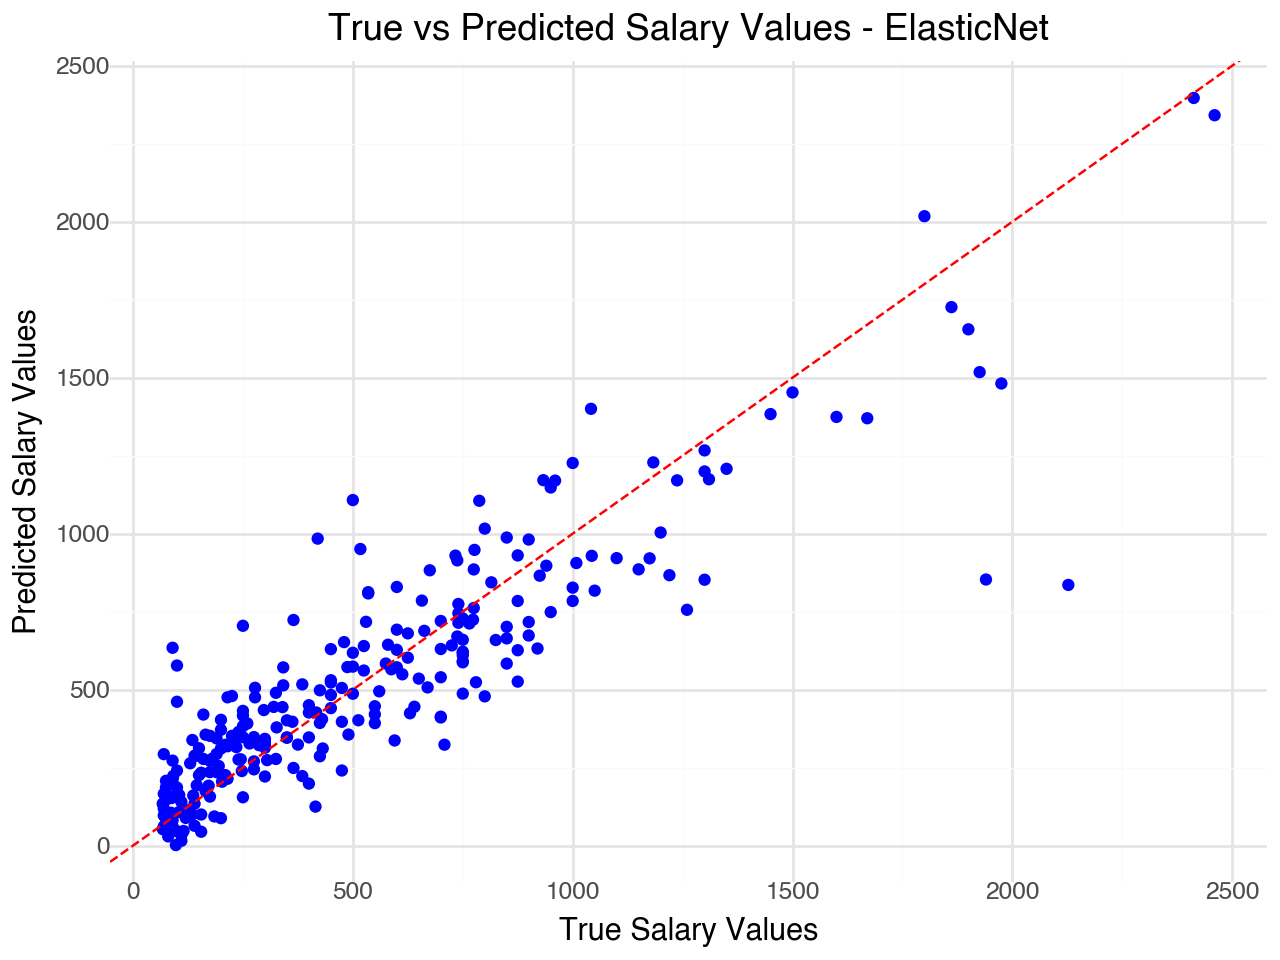

In [94]:
import plotnine as p9
plot = 1
(
    p9.ggplot(prediction_df, p9.aes(x='True Values', y='Predicted Values')) +
    p9.geom_point(color='blue') +  # Scatter plot for predictions
    p9.geom_abline(slope=1, intercept=0, color='red', linetype='dashed') +  # Perfect prediction line
    p9.ggtitle("True vs Predicted Salary Values - ElasticNet") +
    p9.xlab("True Salary Values") +
    p9.ylab("Predicted Salary Values") +
    p9.theme_minimal()
 )


Here we have a plot of the predicted and actual salaries for the best model which was the lasso model where all the varibles for the dataset are included and the interaction between categorical varibles. For the actual high salaries it seems the predictions are much lower and didnt correcly predict them like the lower salaries did.

Chat-gpt was used throughout the lab for the usual debugging. It was also used for the automation and function riting to streamline my code so it would be more efficient when creating the differnt models. It was also used to help create the end plot with predicted and actual salaries.